## Understanding and predicting blight ticket compliance
According to a 2020 study conducted by the University of Michigan on the Detroit community, nearly three quarters of respondents reported blighted properties in their area. [¹](https://detroitsurvey.umich.edu/wp-content/uploads/2021/02/Blight-Report-7-21-2020.pdf) Blight is a situation where owners fail to maintain their property resulting in either danger of the building collapsing, the building potentially being a hub for immoral acts or deemed unsanitary for human inhabitation. [²](https://detroitmi.gov/departments/law-department/blight) As a result, residents in neighborhoods of blighted properties report **lower neighborhood satisfaction** and **lower perceived safety**. [¹](https://detroitsurvey.umich.edu/wp-content/uploads/2021/02/Blight-Report-7-21-2020.pdf) This is a serious issue affecting the city of Detroit, so each year the city issues millions of dollars in fines to owners of blighted properties, but many of these remain unpaid. Since enforcing blight is **tedious and costly**, it would be useful to understand and predict blight ticket compliance so that the city council can be more effective at enforcing blight fines.

This project is the fourth assignment in the Applied Machine Learning in Python course [³](https://www.coursera.org/learn/python-machine-learning) by the University of Michigan offered through Coursera.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.size'] = 14
plt.rcParams['axes.linewidth'] = 2

#importing data
train_df = pd.read_csv("train.csv", encoding='cp1252',low_memory = False)
test_df = pd.read_csv("test.csv", encoding='cp1252',low_memory = False)
address_df = pd.read_csv("addresses.csv", encoding='cp1252',low_memory = False)
latlon_df = pd.read_csv("latlons.csv", encoding='cp1252',low_memory = False)

#ensuring that all instances correspond to only cases from the USA.
train_df = train_df[train_df.country == 'USA']
test_df = test_df[test_df.country == 'USA']

#merging addresses and coordinates with the original dataset
address_df = pd.merge(address_df,latlon_df, on = 'address')
train_df = pd.merge(train_df, address_df, on = 'ticket_id')
test_df = pd.merge(test_df, address_df, on = 'ticket_id')

### Data processing

#### Reducing the number of input features

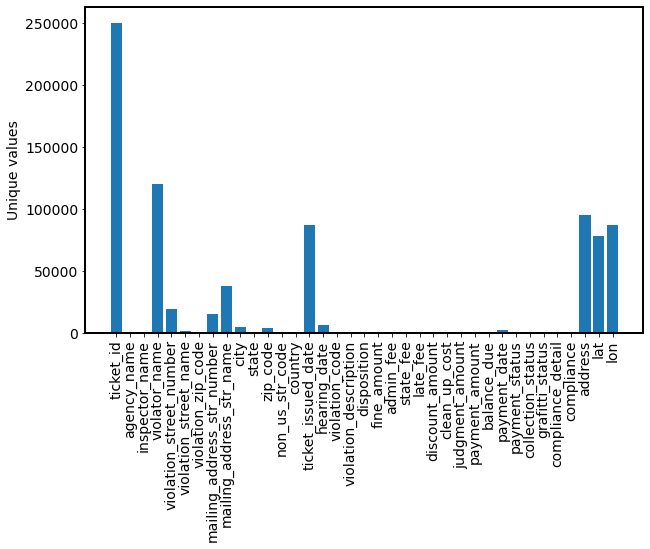

In [2]:
unique_cat = []
for i in train_df.columns:
    unique_cat.append(len(train_df[i].unique()))

fig = plt.figure(figsize=(10,6))
plt.bar(train_df.columns,unique_cat)
fig.patch.set_facecolor('white')
plt.xticks(rotation=90)
plt.ylabel('Unique values')
plt.savefig('Plots/Unique_values',bbox_inches='tight',transparent=False)
plt.show()

- These features will be removed as the number of unique values as stated below are very large, thus these features are unlikely to be useful for prediction.
    - Inspector name(173)
    - Violator name(approx. 120000)
    - Violation street number & name(approx. 19000 & approx. 1800)
    - Maling address street number & name(approx. 16000 & approx. 38000)
    - Zip code(approx. 4000)
    - Violation description (258)
    - Address(approx. 96000)
- The following features are the same for all instances, hence will not be useful for prediction.
    - City, state, country, admin fee, state fee and clean up cost
- The violation zip code has a large proportion of missing values.
- Payment amount, balance due, payment date, payment status, collection status, compliance detail and late fee will be removed to prevent data leakage.

In [17]:
# for i in range(len(unique_cat)):
#     print(train_df.columns[i],": ", unique_cat[i])

#### Introducing a new feature, time to hearing

In [3]:
train_df2 = train_df.copy()
test_df2 = test_df.copy()
columns_to_remove = ['inspector_name', 'violator_name','violation_street_number', 'violation_street_name','violation_zip_code', 'mailing_address_str_number','mailing_address_str_name', 'city', 'state', 'zip_code','non_us_str_code', 'country', 'violation_description','admin_fee', 'state_fee','clean_up_cost','payment_amount', 'balance_due','payment_date', 'payment_status', 'collection_status','compliance_detail','address','grafitti_status','late_fee']
test_col_to_remove = ['inspector_name', 'violator_name','violation_street_number', 'violation_street_name','violation_zip_code', 'mailing_address_str_number','mailing_address_str_name', 'city', 'state', 'zip_code','non_us_str_code', 'country','violation_description','admin_fee', 'state_fee','clean_up_cost','grafitti_status','address','late_fee']
train_df2.drop(columns=columns_to_remove, inplace=True)
test_df2.drop(columns=test_col_to_remove, inplace=True)

#removing instances where the hearing date is missing (5% of the dataset)
train_df2 = train_df2[train_df2.hearing_date.isnull()==False]
test_df2 = test_df2[test_df2.hearing_date.isnull()==False]

#introducing a new feature, time to hearing(days)
train_df2['time_difference'] = (pd.to_datetime(train_df2['hearing_date'])-pd.to_datetime(train_df2['ticket_issued_date'])).dt.days
train_df2.drop(columns=['ticket_issued_date','hearing_date'], axis=1, inplace=True)
test_df2['time_difference'] = (pd.to_datetime(test_df2['hearing_date'])-pd.to_datetime(test_df2['ticket_issued_date'])).dt.days
test_df2.drop(columns=['ticket_issued_date','hearing_date'], axis=1, inplace=True)

#removing instances where the violator was not found to be responsible
train_df2 = train_df2[train_df2.compliance.isnull() == False]

#removing instances where the latitude and longitude data are missing (less than 0.1% of the dataset)
train_df2 = train_df2[train_df2.lat.isnull()!=True]
train_df2 = train_df2[train_df2.lon.isnull()!=True]
test_df2 = test_df2[test_df2.lat.isnull()!=True]
test_df2 = test_df2[test_df2.lon.isnull()!=True]

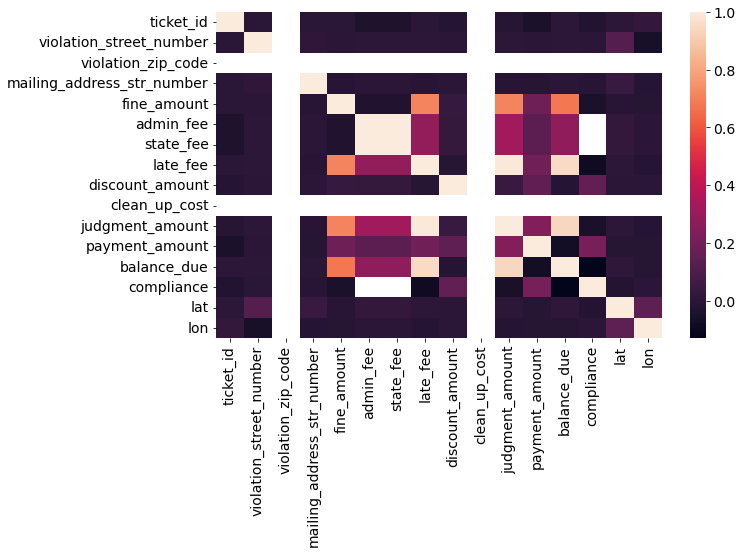

In [4]:
fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
correlation = train_df.corr()
sns.heatmap(correlation)
plt.savefig('Plots/Correlation_train_df',bbox_inches='tight')

As a simplistic overview, compliance seems to have a high correlation with discount amount and payment amount (leaked data).

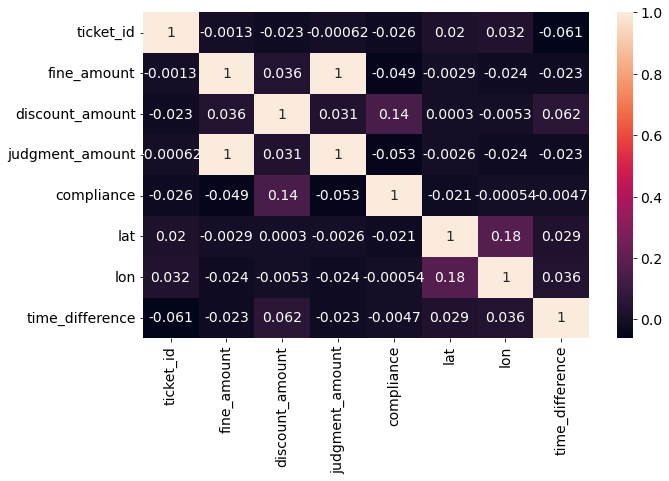

In [5]:
fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
correlation2 = train_df2.corr()
sns.heatmap(correlation2, annot=True)
plt.savefig('Plots/Correlation_train_df2',bbox_inches='tight')

As a simplistic overview, discount amount seem to have a high correlation with compliance.

#### Using the label encoder to convert categorical data into numerical data.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

#using the label encoder to convert categorical data into numerical data.
train_df3 = train_df2.copy()
le = LabelEncoder()
for i in ['violation_code', 'agency_name', 'disposition']:
    train_df3[i] = le.fit_transform(train_df3[i])
for i in ['violation_code', 'agency_name', 'disposition']:
    test_df2[i] = le.fit_transform(test_df2[i])

#splitting the dataset for training and testing purposes(default 80/20 split).
train_df4 = train_df3.copy()
train_df4.drop(columns=['compliance'], axis=1, inplace=True)
X = train_df4
y = train_df3.compliance
X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=0)

#normalisation of all the features in the dataset
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

### Exploratory Data Analysis

In [51]:
#subdividing the cleaned dataset into two new datasets, where compliance = 0 or 1 respectively.
paid = train_df2[train_df2.compliance==1]
not_paid= train_df2[train_df2.compliance==0]

In [47]:
#returns means of compliant and not compliant cases for each feature
def meanscounts(feature,verbose=False):
    means = [paid[feature].mean(axis=0),not_paid[feature].mean(axis=0)]
    count = [len(paid[feature]),len(not_paid[feature])]
    print('non-compliant \\ ','mean: ', means[1],'total : ', count[1])
    print('compliant \\ ','mean: ', means[0],'total : ', count[0])
    return

Percentage of non-compliance cases: [93.97175335859455, 91.18277101981485, 93.5193012116089, 86.90582959641256]


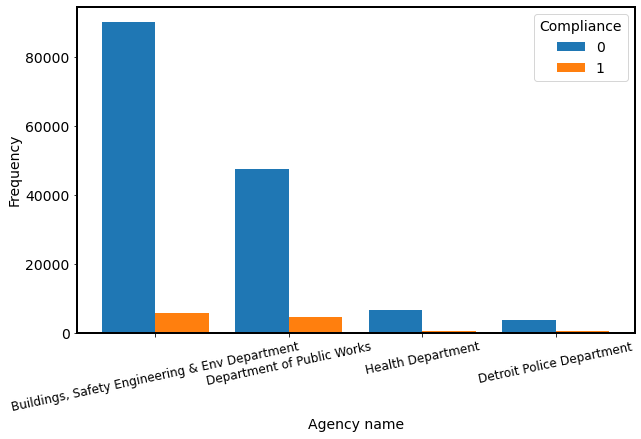

In [74]:
freq_paid = paid.agency_name.value_counts().tolist().copy()
freq_paid[2:4] = [int(460), int(584)]
freq_not_paid = not_paid.agency_name.value_counts().tolist()[:-1]
name_not_paid = 'Buildings, Safety Engineering & Env Department' ,'Department of Public Works','Health Department','Detroit Police Department'

per = []
for i in range(len(freq_paid)):
    per.append((freq_not_paid[i]/(freq_paid[i]+freq_not_paid[i]))*100)

X_axis = np.arange(len(name_not_paid))
fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
plt.bar(X_axis-0.2,freq_not_paid, 0.4, label ='0')
plt.bar(X_axis+0.2, freq_paid, 0.4, label='1')
plt.xticks(X_axis,name_not_paid,rotation=12,fontsize=12)
plt.ylabel('Frequency',fontsize=14)
plt.xlabel('Agency name',fontsize=14)
plt.legend(title = 'Compliance',fontsize=14,title_fontsize=14)
plt.savefig('Plots/Frequency_vs_Agency_name',bbox_inches='tight')
print('Percentage of non-compliance cases:', per)

Buildings, Safety Engineering and Env Department as well as the Health Department have higher proportions of non-compliant cases.

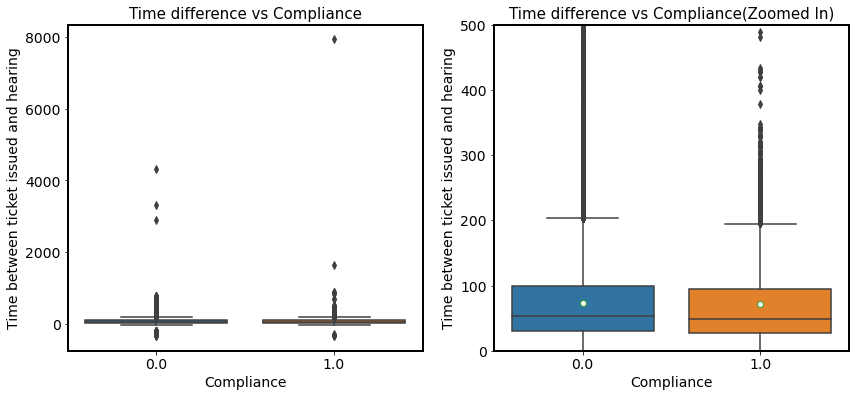

In [76]:
fig = plt.figure(figsize=(14,6))
fig.patch.set_facecolor('white')
plt.subplot(1,2,1)
bp = sns.boxplot(x=train_df2.compliance, y=train_df2.time_difference)
plt.title('Time difference vs Compliance', fontsize=15)
plt.ylabel('Time between ticket issued and hearing')
plt.xlabel('Compliance')

plt.subplot(1,2,2)
bp2 = sns.boxplot(x=train_df2.compliance, y=train_df2.time_difference,showmeans=True, meanprops={'marker':'o','markerfacecolor':'white'})
bp2.set(ylim=(0,500))
plt.title('Time difference vs Compliance(Zoomed In)', fontsize=15)
plt.ylabel('Time between ticket issued and hearing')
plt.xlabel('Compliance')
plt.savefig('Plots/Time_diff_vs_Compliance.png')
plt.show()

In [9]:
meanscounts('time_difference')

non-compliant \  mean:  72.73173381193028 total :  148211
compliant \  mean:  71.58719048035698 total :  11429


The mean time difference for non-compliant cases is slightly higher than the mean time difference for compliant cases. The means are annotated with white circles. 

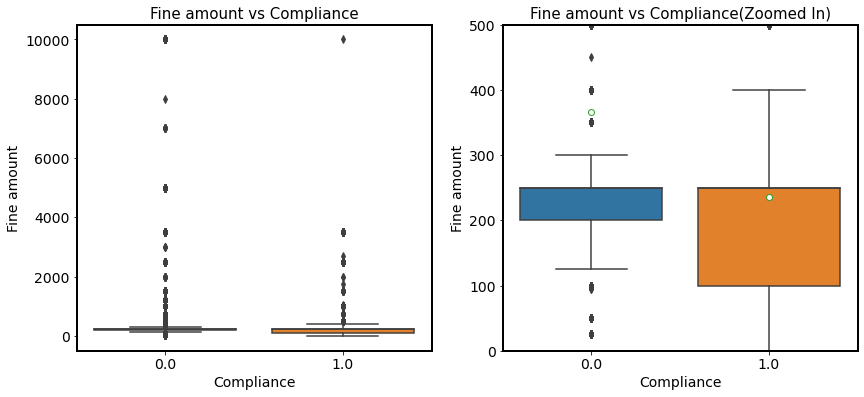

In [45]:
fig = plt.figure(figsize=(14,6))
fig.patch.set_facecolor('white')
plt.subplot(1,2,1)
bp = sns.boxplot(x=train_df2.compliance, y=train_df2.fine_amount)
plt.title('Fine amount vs Compliance', fontsize=15)
plt.ylabel('Fine amount')
plt.xlabel('Compliance')

plt.subplot(1,2,2)
bp2 = sns.boxplot(x=train_df2.compliance, y=train_df2.fine_amount,showmeans=True, meanprops={'marker':'o','markerfacecolor':'white'})
bp2.set(ylim=(0,500))
plt.title('Fine amount vs Compliance(Zoomed In)', fontsize=15)
plt.ylabel('Fine amount')
plt.xlabel('Compliance')
plt.savefig('Plots/Fine_am_vs_Compliance.png')
plt.show()

In [52]:
meanscounts('fine_amount')

non-compliant \  mean:  366.1413255426385 total :  148211
compliant \  mean:  236.45822031673814 total :  11429


The mean fine amount for non compliant cases is higher than for compliant cases.

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


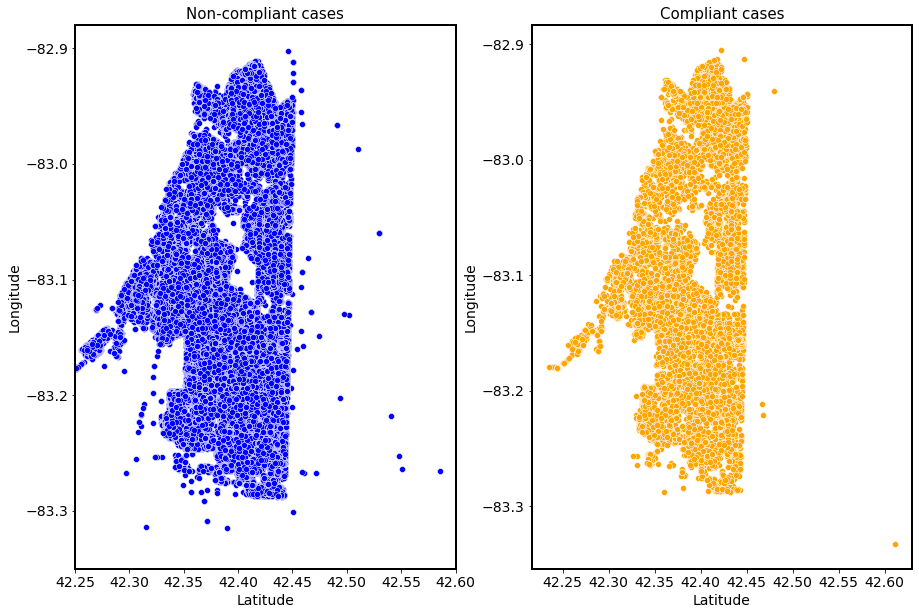

In [78]:
paid_lat = paid['lat']
paid_lon = paid['lon']
not_paid_lat = not_paid['lat']
not_paid_lon = not_paid['lon']

fig = plt.figure(figsize=(15,10))
fig.patch.set_facecolor('white')

plt.subplot(1,2,1)
sns.scatterplot(not_paid_lat, not_paid_lon, color='blue')
plt.title('Non-compliant cases', fontsize=15)
plt.xlim(42.25,42.6)
plt.ylim(-83.35,-82.88)
plt.ylabel('Longitude')
plt.xlabel('Latitude')

plt.subplot(1,2,2)
# sns.scatterplot(train_df2['lat'], train_df2['lon'], hue=train_df2['compliance'])
sns.scatterplot(paid_lat, paid_lon, color='orange')
plt.title('Compliant cases', fontsize=15)
plt.ylabel('Longitude',fontsize=14)
plt.xlabel('Latitude')

plt.savefig('Plots/LatvsLon_Compliant&NonCompliant.png', bbox_inches='tight')
plt.show()

The non-compliant dataset shows more variation in scatter points compared to the compliant dataset, which is much smaller than the non-compliant dataset. Interestingly, the majority of scatter points for non-compliant cases match the pattern of scatter points for compliant cases, which would suggest that both compliant and non-compliant cases shared the same subset of addresses.

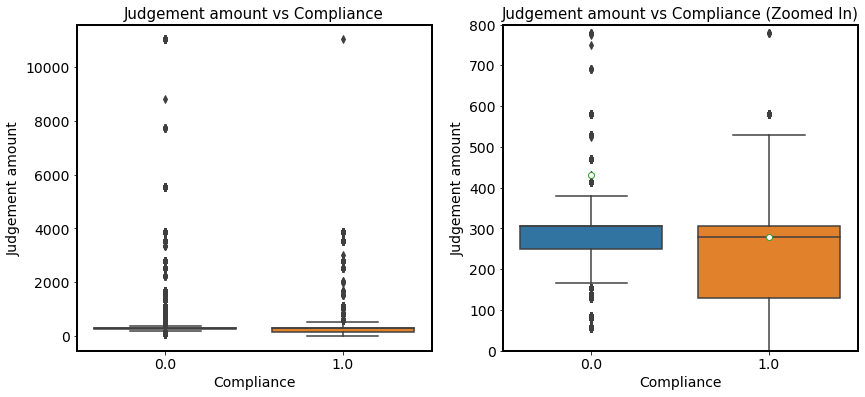

In [81]:
fig = plt.figure(figsize=(14,6))
fig.patch.set_facecolor('white')

plt.subplot(1,2,1)
bp = sns.boxplot(x=train_df2.compliance, y=train_df2.judgment_amount)
plt.title('Judgement amount vs Compliance',fontsize=15)
plt.ylabel('Judgement amount')
plt.xlabel('Compliance')

plt.subplot(1,2,2)
bp2 = sns.boxplot(x=train_df2.compliance, y=train_df2.judgment_amount,showmeans=True, meanprops={'marker':'o','markerfacecolor':'white'})
bp2.set(ylim=(0,800))
plt.title('Judgement amount vs Compliance (Zoomed In)', fontsize=15)
plt.ylabel('Judgement amount')
plt.xlabel('Compliance')
plt.savefig('Plots/Judgement_amount_vs_compliance.png', bbox_inches='tight')
plt.show()

In [12]:
meanscounts('judgment_amount')

non-compliant \  mean:  431.3887579194527 total :  148211
compliant \  mean:  279.09726135269926 total :  11429


The mean judgement amount for non-compliant cases is much higher than for compliant cases. This may be a useful feature for prediction.

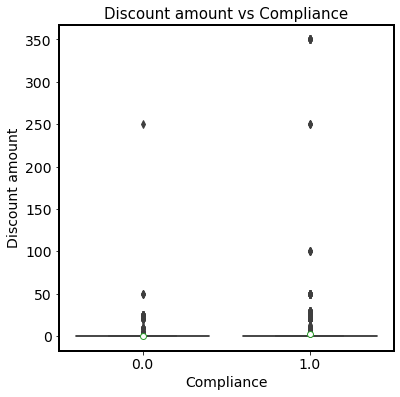

In [83]:
fig = plt.figure(figsize=(6,6))
fig.patch.set_facecolor('white')

bp = sns.boxplot(x=train_df2.compliance, y=train_df2.discount_amount,showmeans=True,meanprops={'marker':'o','markerfacecolor':'white'})
plt.ylabel('Discount amount')
plt.xlabel('Compliance')
plt.title('Discount amount vs Compliance',fontsize=15)
plt.savefig('Plots/Discount_amount_vs_compliance.png', bbox_inches='tight')
plt.show()

In [14]:
meanscounts('discount_amount')

non-compliant \  mean:  0.008703807409706433 total :  148211
compliant \  mean:  2.2241665937527344 total :  11429


The distribution of discount amounts are very similar for compliant and non-compliant cases. The compliant cases have a larger variation in discount amount and a greater number of outliers. The mean for compliant cases is slightly higher than the mean for non-compliant cases.

In [76]:
not_paid_dis=[]
for i in range(len(paid)):
    if not_paid['discount_amount'].iloc[i]>0:
        not_paid_dis.append([not_paid['discount_amount'].iloc[i],not_paid['ticket_id'].iloc[i]])

paid_dis=[]
for i in range(len(paid)):
    if paid['discount_amount'].iloc[i]>0:
        paid_dis.append([paid['discount_amount'].iloc[i],paid['ticket_id'].iloc[i]])
        
print(not_paid_dis)

[[50.0, 32300], [20.0, 33415]]


In [78]:
len(paid_dis)

998

There are only two instances of discounts among non-compliant cases vs 998 instances of discounts among compliant cases. Ideally, a larger dataset would be needed to establish a relationship between discount amount and compliance as the current data for discount amount is very limited.

Percentage of non-compliance cases: [96.22644239464641, 69.77389924633081, 72.65076112412177, 0.0]


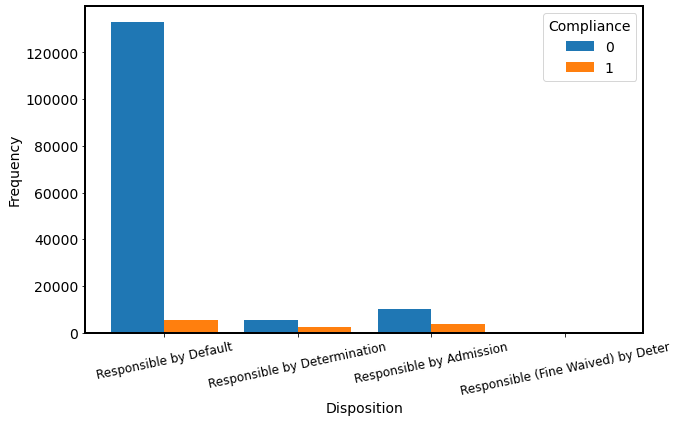

In [86]:
paid_disp = paid.disposition.value_counts().tolist()
paid_disp[1:3]=[2286,3737]
not_paid_disp = not_paid.disposition.value_counts().tolist()
not_paid_disp.append(0)
not_paid_disp[1:3]=[5277,9927]
disp_cat = train_df2.disposition.unique()
X_axis = np.arange(len(disp_cat))

per = []
for i in range(len(not_paid_disp)):
    per.append((not_paid_disp[i]/(not_paid_disp[i]+paid_disp[i]))*100)

fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
plt.bar(X_axis-0.2,not_paid_disp, 0.4, label ='0')
plt.bar(X_axis+0.2,paid_disp , 0.4, label='1')
plt.xticks(X_axis,disp_cat,rotation=12,fontsize=12)
plt.ylabel('Frequency',fontsize=14)
plt.xlabel('Disposition',fontsize=14)
plt.legend(title = 'Compliance',fontsize=14,title_fontsize=14)
plt.savefig('Plots/Frequency_vs_Disposition',bbox_inches='tight')
print('Percentage of non-compliance cases:', per)

The percentage of non-compliant cases for the responsible by default category is much higher compared to the other categories.

### Modelling and model evaluation

In [7]:
# Model evaluation function
from sklearn.metrics import roc_auc_score, confusion_matrix

def model_score(X_train, X_test, y_train, y_test, y_pred,y_df, model):
    print("Training set accuracy: ", model.score(X_train,y_train))
    print("Test set accuracy: ", model.score(X_test,y_test))
    print("AUC ROC Score: ", roc_auc_score(y_test, y_df))
    confusion = confusion_matrix(y_test, y_pred)
    specificity = confusion[0][0]/(confusion[0][0]+confusion[0][1])
    print("Specificity: ", specificity)
    
    return

Specificity was included as a metric as the aim of this project is to identify as many individuals as possible who might not pay the fines on time, so that the enforcers can channel more effort early on to ensure that these individuals pay the fines. The area under the ROC curve was included to assess the models' performance at distinguishing positive and negative classes.

#### Building unoptimised models (Logistic Regression, Random Forest Classifier and XGBoost Classifier)

In [358]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

#unoptimised models
lg_clf_base = LogisticRegression(random_state=0,max_iter=400).fit(X_train_scaled,y_train)
y_pred_b = lg_clf_base.predict(X_test_scaled)
y_df_b = lg_clf_base.decision_function(X_test_scaled)
print(model_score(X_train_scaled, X_test_scaled, y_train, y_test, y_pred_b, y_df_b, lg_clf_base))

ran_for_clf_base = RandomForestClassifier(random_state=0).fit(X_train_scaled,y_train)
y_pred2_b = ran_for_clf_base.predict(X_test_scaled)
y_df2_b = ran_for_clf_base.predict_proba(X_test_scaled)
print(model_score(X_train_scaled, X_test_scaled, y_train, y_test, y_pred2_b, y_df2_b[:,1], ran_for_clf_base))

xgb_clf_base = XGBClassifier(random_state=0).fit(X_train_scaled,y_train)
y_pred3_b = xgb_clf_base.predict(X_test_scaled)
y_df3_b = xgb_clf_base.predict_proba(X_test_scaled)
scores.append(model_score(X_train_scaled, X_test_scaled, y_train, y_test, y_pred3_b, y_df3_b[:,1], xgb_clf_base))

Training set accuracy:  0.9295665246805312
Test set accuracy:  0.9259584064144325
AUC ROC Score:  0.6337528276289648
Specificity:  0.9999729320051971
None
Training set accuracy:  0.9999415351206882
Test set accuracy:  0.9221498371335505
AUC ROC Score:  0.7249517284383983
Specificity:  0.9720658293633607
None
Training set accuracy:  0.9499707675603442
Test set accuracy:  0.9321222751190178
AUC ROC Score:  0.6691115137868268
Specificity:  0.9840298830662625


All classifiers were overfitting, especially the Random Forest Classifier. This makes sense as the default max_depth parameter for the Random Forest Classifier is set as None. 

#### Searching for optimal parameters using GridSearchCV for Logistic Regression 

In [15]:
from sklearn.model_selection import GridSearchCV
param_values={'C':np.logspace(-3,3,7)}
lg_grid = GridSearchCV(lg_clf_base, param_grid=param_values,scoring='roc_auc',cv=3).fit(X_train,y_train)

In [17]:
#pd.DataFrame(data = lg_grid.cv_results_)

#### Searching for optimal parameters using GridSearchCV for Random Forest Classifier

In [65]:
param_values={'n_estimators':[100,200,300], 'max_features':[3,6,8], 'max_depth':[5,10]}
ran_for_grid = GridSearchCV(ran_for_clf_base, param_grid=param_values,scoring='roc_auc',cv=3).fit(X_train,y_train)

In [338]:
# pd.DataFrame(data = ran_for_grid.cv_results_)

#### Searching for optimal parameters using GridSearchCV for XGBoost Classifier

In [311]:
param_values = {'eta':[0.01,0.1,1], 'max_depth':[3, 4, 5, 7]}
xgb_grid = GridSearchCV(xgb_clf, param_grid = param_values,scoring='roc_auc',cv=3).fit(X_train, y_train)

In [373]:
# pd.DataFrame(data = xgb_grid.cv_results_)

#### Building optimised models

In [28]:
# baseline model
scores=[]
lg_clf = LogisticRegression(C=10, max_iter=400, random_state=0).fit(X_train_scaled,y_train)
y_pred = lg_clf.predict(X_test_scaled)
y_df = lg_clf.decision_function(X_test_scaled)
scores.append(model_score(X_train_scaled, X_test_scaled, y_train, y_test, y_pred, y_df, lg_clf))

#Random Forest Classifier
ran_for_clf = RandomForestClassifier(n_estimators=100, max_depth=10, max_features=3, random_state=0).fit(X_train,y_train)
y_pred2 = ran_for_clf.predict(X_test)
y_df2 = ran_for_clf.predict_proba(X_test)
scores.append(model_score(X_train, X_test, y_train, y_test, y_pred2, y_df2[:,1], ran_for_clf))

#XGBoost Classifier
xgb_clf = XGBClassifier(objective = 'binary:logistic',max_depth = 5,learning_rate=0.1,random_state=0,eval_metric='auc').fit(X_train_scaled, y_train)
y_pred3 = xgb_clf.predict(X_test_scaled)
y_df3 = xgb_clf.predict_proba(X_test_scaled)
scores.append(model_score(X_train_scaled, X_test_scaled, y_train, y_test, y_pred3, y_df3[:,1], xgb_clf))

Training set accuracy:  0.933425206715109
Test set accuracy:  0.9295414683036833
AUC ROC Score:  0.6515234772783622
Specificity:  0.9999187960155912
Training set accuracy:  0.9446838720454356
Test set accuracy:  0.9407917815083939
AUC ROC Score:  0.8245026616435671
Specificity:  0.9988090082286705


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


Training set accuracy:  0.9449427879395306
Test set accuracy:  0.9390879478827362
AUC ROC Score:  0.7044032782973892
Specificity:  0.9954796448679082


### Plotting the five most important features for prediction

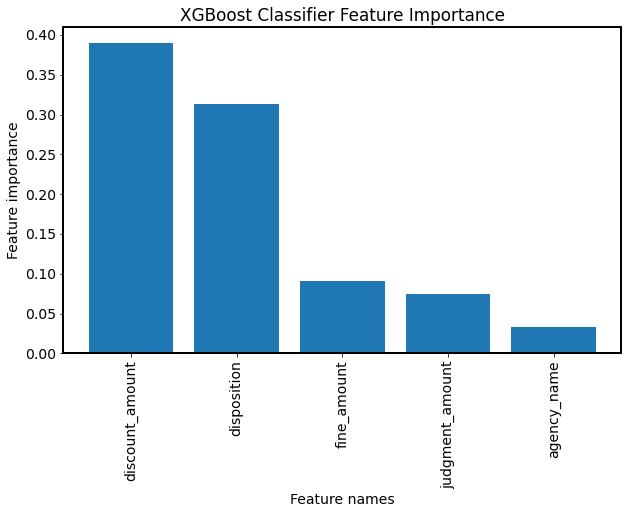

In [29]:
mean_impor = xgb_clf.feature_importances_
fig = plt.figure(figsize=(10,6))
fig.patch.set_facecolor('white')
sorted_per = mean_impor.argsort()[-5:][::-1]
plt.bar(test_df2.columns[sorted_per],mean_impor[sorted_per])
plt.ylabel('Feature importance')
plt.xlabel('Feature names')
plt.title('XGBoost Classifier Feature Importance')
plt.xticks(rotation=90)
plt.savefig('Plots/XGBoostClassifierFeatureImportance', bbox_inches='tight')

Discount amount is the most important predictor, followed by disposition, fine amount, judgement amount and agency name.

### Predicting blight ticket compliance

In [37]:
pred = pd.Series(xgb_clf.predict(test_df2), index = test_df2.ticket_id)
print(pred)

ticket_id
284932    0.0
285362    0.0
285361    0.0
285338    0.0
285346    0.0
         ... 
376496    0.0
376497    0.0
376499    0.0
376500    0.0
369851    0.0
Length: 58799, dtype: float64


In [38]:
prob = pd.Series(xgb_clf.predict_proba(test_df2)[:,1],index = test_df2.ticket_id)
print(prob)

ticket_id
284932    0.093295
285362    0.093295
285361    0.093295
285338    0.093295
285346    0.093295
            ...   
376496    0.093295
376497    0.093295
376499    0.093295
376500    0.093295
369851    0.093295
Length: 58799, dtype: float32


In [39]:
pred.value_counts()

0.0    58084
1.0      715
dtype: int64

In [40]:
pred.value_counts()[1]/(pred.value_counts()[0]+pred.value_counts()[1])*100

1.2160070749502543

The predicted percentage of compliance is 1.2%.

In [42]:
prob.to_csv("Probability_of_blight_compliance.csv")
pred.to_csv("Prediction_of_blight_compliance.csv")